In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


#This is relative imports

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex
from sklearn import preprocessing as sklpp
from sklearn import decomposition as skldecomp
import seaborn as sn #This is to make confusion matrices look nice
import time

#Exploring the data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/car_evaluation.csv')
df

,buying price,maintenance cost,number of doors,number of persons,lug_boot,safety,decision
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [ ]:
print(f'Number of DataSamples: {df.shape[0]}')
print(f'Number of features: {df.shape[1]}')

Number of DataSamples: 1728
Number of features: 7


There are a total of 6 categroical features and one label

vhigh    432
high     432
med      432
low      432
Name: buying price, dtype: int64
vhigh    432
high     432
med      432
low      432
Name: maintenance cost, dtype: int64
2        432
3        432
4        432
5more    432
Name: number of doors, dtype: int64
2       576
4       576
more    576
Name: number of persons, dtype: int64
small    576
med      576
big      576
Name: lug_boot, dtype: int64
low     576
med     576
high    576
Name: safety, dtype: int64
unacc    1210
acc       384
good       69
vgood      65
Name: decision, dtype: int64


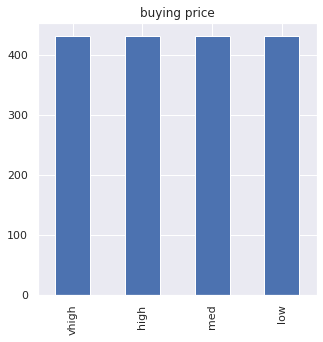

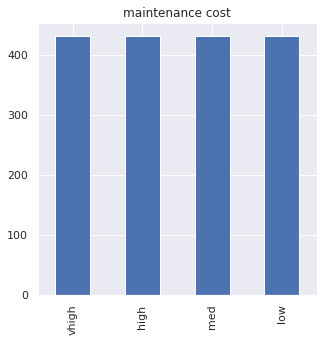

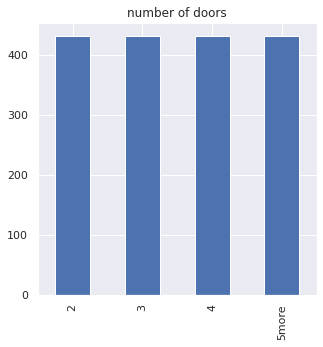

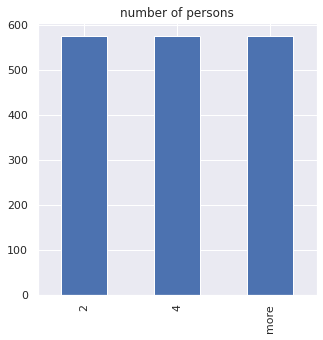

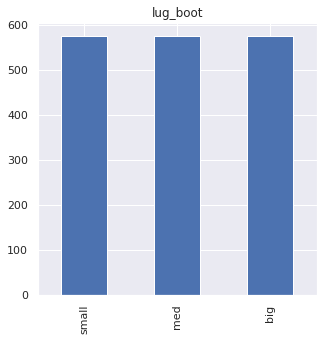

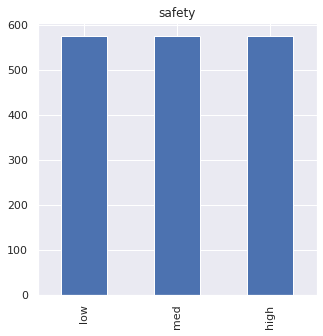

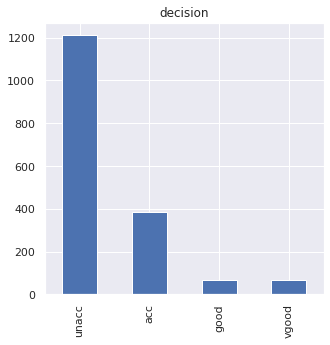

In [ ]:
for col in df:
  fig= plt.figure()
  plt.title(col)
  df[col].value_counts().plot.bar(figsize = [5,5])
  print(df[col].value_counts())

One can see that the distribution of features is quite even. However, the prior probability of unacc is much higher than the other labels.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/car_evaluation.csv')
df['decision'] = df['decision'].replace(to_replace = ['unacc','acc','good','vgood'], value = [0,1,1,1])


class_names = ['unacc', 'acc', 'good', 'vgood']
indexing = np.asarray([True for i in range(df.shape[0])]).astype(bool)
for i in range(df.shape[0]):
    if(np.random.random() < 0.2):
      indexing[i] = False
master_train, master_test = df.loc[indexing], df.loc[~indexing]
master_train.reset_index(drop = True, inplace = True)
master_test.reset_index(drop = True, inplace = True)

A master set of training and testing data is made here. This is so that testing and training data is never mixed throughout the notebook. 'good' and 'vgood' are set as 'acc'. This is because they are underrepresented in this dataset. In addition, they mean the same thing as 'acc', so to make a more uniform dataset, they are changed to 'acc'.

#Naive Bayes

In [ ]:
df_train = master_train.copy()
df_test = master_test.copy()

naiveBayesStart = time.time()
classes = df_train.groupby('decision')
probs = [{'buying price': {},'maintenance cost': {}, 'number of doors': {}, 'number of persons': {},
         'lug_boot': {}, 'safety': {}} for i in range(2)]


for i in df_train.columns.drop(labels = 'decision'):
  uniqueVals = df[i].unique()
  for j in range(2):
    currClass = classes.get_group(j)
    for k in range(len(uniqueVals)):
      if(uniqueVals[k] in currClass[i].unique()):
        prob = currClass[i].value_counts()[uniqueVals[k]]
        prob = prob/currClass.shape[0]
        #print(probs[i])
        probs[j][i][uniqueVals[k]] = prob
      else:
        probs[j][i][uniqueVals[k]] = 0

print(probs[0])
print(probs[1])

naiveBayesTrainTime = time.time()-naiveBayesStart


{'buying price': {'vhigh': 0.3107287449392713, 'high': 0.2692307692307692, 'med': 0.2125506072874494, 'low': 0.2074898785425101}, 'maintenance cost': {'vhigh': 0.2935222672064777, 'high': 0.2702429149797571, 'med': 0.22064777327935223, 'low': 0.21558704453441296}, 'number of doors': {'2': 0.2682186234817814, '3': 0.24898785425101214, '4': 0.24898785425101214, '5more': 0.23380566801619435}, 'number of persons': {'2': 0.4797570850202429, '4': 0.2591093117408907, 'more': 0.2611336032388664}, 'lug_boot': {'small': 0.3734817813765182, 'med': 0.3259109311740891, 'big': 0.3006072874493927}, 'safety': {'low': 0.4645748987854251, 'med': 0.3006072874493927, 'high': 0.23481781376518218}}
{'buying price': {'vhigh': 0.11056511056511056, 'high': 0.21867321867321868, 'med': 0.32923832923832924, 'low': 0.3415233415233415}, 'maintenance cost': {'vhigh': 0.14496314496314497, 'high': 0.22358722358722358, 'med': 0.3194103194103194, 'low': 0.31203931203931207}, 'number of doors': {'2': 0.20147420147420148,

Nested dictionaries are used to store the probabilities. This is for ease of looking up the probabilities later.

In [ ]:
#Test Sample is Panadas row
def runNaiveBayes(testSample):
  preds = np.ones(2)
  for i in testSample.keys().drop('decision'):
      preds[0] = preds[0]*probs[0][i][testSample[i]]
      preds[1] = preds[1]*probs[1][i][testSample[i]]
  return np.argmax(preds)

testNum = 30
print("Predicted: {}".format(runNaiveBayes(df_test.iloc[testNum])))
print("Actual: {}".format(df_test['decision'].iloc[testNum]))

Predicted: 0
Actual: 0


#Decision Tree

In the most general terms, a decision tree is a machine learning algorithm which inquires about feature values. More specifically, at each node of the decision tree, there is a question. The question is about the value of a certain feature. Using the datasample, the tree picks a branch to follow. This process of running down the tree continues until it reaches a leaf node. At a leaf node, there is a distribution of the labels. Essentially, whichever label occurs the most is the predicted value. What makes a decision tree work is that each question is asked in a specific order. The next question that is asked is the question that provides the most information about the dataset. This way it will split the dataset in an optimal way.
Sources for Decision Tree:
https://towardsdatascience.com/decision-tree-in-machine-learning-e380942a4c96
; ISL Textbook

In [ ]:
df_train = master_train.copy()
df_train['decision'] = df_train['decision'].replace(to_replace = [0,1], value = ['unacc', 'acc'])
df_test = master_test.copy()
df_test['decision'] = df_test['decision'].replace(to_replace = [0,1], value = ['unacc', 'acc'])

In [ ]:
def gini(rows):
  counts = rows['decision'].value_counts()
  impurity = 1
  for i in counts:
    prob_of_lbl = i/float(rows.shape[0])
    impurity -= prob_of_lbl**2
  return impurity


def info_gain(left, right, current_uncertainty):
    p = float(left.shape[0]) / (left.shape[0] + right.shape[0])
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)

def findBestSplit(df):
  best_gain = 0
  best_fn = None
  current_uncertainty = gini(df)
  for col in df:
    if(col == "decision"):
      continue
    vals = df[col].unique()

    for val in vals:
      fn = lambda x, v = val, c = col: x[c] == v
      trueDf, falseDf = df.loc[fn(df)], df.loc[~fn(df)]

      if(trueDf.shape[0] == 0 or falseDf.shape[0]==0):
        continue

      gain = info_gain(trueDf, falseDf, current_uncertainty)
      if(gain >= best_gain):
        best_gain, best_fn= gain, fn
  return best_gain, best_fn


split tree finds the question that will have the highest information gain. This information gain is calculated using the gini value. The gini value is how unequal the distributions are. The question with the best gain value is saved and returned. The question is represented by an anonymous function.

In [ ]:
class Leaf:
  def __init__(self, df):
    self.preds = df['decision'].value_counts() #Value counts is in decending order
class Decision:
  def __init__(self, question, trueBranch, falseBranch):
    self.question = question
    self.trueBranch = trueBranch
    self.falseBranch = falseBranch


def build_tree(df):
    gain, fn = findBestSplit(df)
    if gain == 0:
        return Leaf(df)
    trueDf, falseDf = df.loc[fn(df)], df.loc[~fn(df)]

    true_branch = build_tree(trueDf)
    false_branch = build_tree(falseDf)

    return Decision(fn, true_branch, false_branch)

This is building the tree structure. The tree is most easily represented by having the nodes as objects. Decision nodes hold the question and the dataset contained in each branch. Leaf nodes hold the number of occurances of each label. build_tree is a recursive function that builds a tree. It does this by assuming each branch of a node is another decision tree using the branches dataset. It will keep running this assumption until the information gain is zero. At this point it will store a leaf.

In [ ]:
treeStartTime = time.time()
treeClassifier = build_tree(df_train)
treeTrainTime = time.time()-treeStartTime

In [ ]:
def classify(df_row, tree):
  if isinstance(tree, Leaf):
    return tree.preds.index[0]
  if(tree.question(df_row)):
    return classify(df_row, tree.trueBranch)
  else:
    return classify(df_row, tree.falseBranch)

Classify is a recursive function. It will run until it hits a leaf node. It then returns the most frequent label. At decision nodes, it evaluates the question and based on the result, chooses to go through the appropriate branch.

In [ ]:
test_num = 205

print(classify(df.loc[test_num],treeClassifier))
print(class_names[df['decision'].iloc[test_num]])

unacc
unacc


In [ ]:
intValue = {'unacc':0, 'acc':1}
confMatrixTree = np.zeros([2,2])
for i in range(df_test.shape[0]):
  predicted = intValue[classify(df_test.iloc[i], treeClassifier)]
  actual = intValue[df_test['decision'].iloc[i]]
  confMatrixTree[actual,predicted] += 1

#KNN


In [ ]:
trainDf = master_train.copy()
testDf = master_test.copy()

In [ ]:
trainDf = trainDf.reset_index()
trainDf['buying price'] = trainDf['buying price'].replace(to_replace = ['vhigh','high','med','low'], value = [3,2,1,0])
trainDf['maintenance cost'] = trainDf['maintenance cost'].replace(to_replace = ['vhigh','high','med','low'], value = [3,2,1,0])
trainDf['number of doors'] = trainDf['number of doors'].replace(to_replace = ['2', '3', '4', '5more'], value = [2,3,4,5])
trainDf['number of persons'] = trainDf['number of persons'].replace(to_replace = ['2','4','more'], value = [2,4,6])
trainDf['lug_boot'] = trainDf['lug_boot'].replace(to_replace = ['small', 'med', 'big'], value = [1,2,3])
trainDf['safety'] = trainDf['safety'].replace(to_replace = ['low', 'med', 'high'], value = [1,2,3])

testDf = testDf.reset_index()
testDf['buying price'] = testDf['buying price'].replace(to_replace = ['vhigh','high','med','low'], value = [3,2,1,0])
testDf['maintenance cost'] = testDf['maintenance cost'].replace(to_replace = ['vhigh','high','med','low'], value = [3,2,1,0])
testDf['number of doors'] = testDf['number of doors'].replace(to_replace = ['2', '3', '4', '5more'], value = [2,3,4,5])
testDf['number of persons'] = testDf['number of persons'].replace(to_replace = ['2','4','more'], value = [2,4,6])
testDf['lug_boot'] = testDf['lug_boot'].replace(to_replace = ['small', 'med', 'big'], value = [1,2,3])
testDf['safety'] = testDf['safety'].replace(to_replace = ['low', 'med', 'high'], value = [1,2,3])

Data is changed to oridinal data to enable to use of KNN. This is because KNN is a distance algorithm and needs numbers to compute distance. Oridnal is used because of the implicit order in the variables. For example, low < medium < high.

In [ ]:
myData = trainDf.drop(columns = ['decision', 'index']).to_numpy()


mean_datascalar = sklpp.StandardScaler(with_mean=True, with_std=True)
trainCenteredDf = mean_datascalar.fit_transform(myData)
trainCenteredDf = pd.DataFrame(trainCenteredDf)
trainCenteredDf.columns = ['buying price', 'maintenance cost', 'number of doors', 'number of persons', 'lug_boot', 'safety']
trainCenteredDf['decision'] = trainDf['decision']
testCenteredDf = mean_datascalar.transform(testDf.drop(columns = ['decision', 'index']).to_numpy())
testCenteredDf = pd.DataFrame(testCenteredDf)
testCenteredDf.columns = ['buying price', 'maintenance cost', 'number of doors', 'number of persons', 'lug_boot', 'safety']
testCenteredDf['decision'] = testDf['decision']

The ordinal data is centered and made to have unit variance. This is so no one feature is more important than another.

In [ ]:
#sample and df are pandas dataframes
def distance(a, b):
  sum = 0
  if(a is None or b is None):
    return np.inf
  for i in range(a.shape[0]-2):
    #+1 bc index counts as 0
    sum += (a[i+1] - b[i+1])**2
  return np.sqrt(sum)

def fastDistance(s, d):
  return np.sqrt(np.sum(np.square(s-d)))


def KNN(sample, k, df):
  priors = [df['decision'].value_counts()[0]/df.shape[0],df['decision'].value_counts()[1]/df.shape[0]]
  kNearestSamples = [None for i in range(k)]
  kDistance = [np.inf for i in range(k)]
  for i in range(df.shape[0]):
    currRow = df.iloc[i]
    currDistance = distance(sample, currRow)
    for j in range(k):
      otherDistance = distance(sample, kNearestSamples[j])
      if(currDistance < otherDistance):
        temp = kNearestSamples[j]
        kNearestSamples[j] = currRow
        kDistance[j] = currDistance
        currRow = temp
        currDistance = otherDistance
      elif(currDistance == otherDistance and not currRow is None):
        if(np.random.random() < priors[currRow['decision']]):
          temp = kNearestSamples[j]
          kNearestSamples[j] = currRow
          kDistance[j] = currDistance
          currRow = temp
          currDistance = otherDistance
  numUnacc = 0
  for i in kNearestSamples:
    if(i['decision'] == 'unacc'):
      numUnacc += 1
  if(numUnacc > k/2):
    return 'unacc', kNearestSamples
  return 'acc', kNearestSamples




KNN(testDf.iloc[0], 3, trainDf)



def fastKNN(sample, k, df):
  #classDictionary = {'unacc':1, 'acc':0}
  npSample = sample[0:6]
  kNearestSamples = np.zeros(k)
  np_df = df.drop(columns = ['decision', 'index']).to_numpy()
  kDistances = np.zeros(df.shape[0])
  kClasses = np.zeros(df.shape[0])
  for i in range(df.shape[0]):
    kSample = np_df[i,:]
    kClass = df['decision'].iloc[i]
    kDistance = fastDistance(npSample, kSample)
    kDistances[i] = kDistance
    kClasses[i] = kClass#classDictionary[kClass]
  ind = np.argsort(kDistances)
  kDistances = kDistances[ind]
  kClasses = kClasses[ind]
  return kClasses

KNN uses numpys argsort to sort the list in asceding order. KNN is not used, rather fastKNN is used. This is because fastKNN uses numpy to sort which is faster. However, this may cause bias for items that are equidistant from the datasample. KNN overcomes this by randomly choosing which datasample is closer based on the prior distributions. This issue is not solved in fastKNN, however the bias introduced vs the time saved calculating justifys this choice.

In [ ]:
def split(k, df):
  folds = [pd.DataFrame() for i in range(k)]
  dfCopy = df.copy()
  kth = 0
  for i in range(df.shape[0]):
    randInt = np.random.randint(0,dfCopy.shape[0])
    folds[kth] = folds[kth].append(dfCopy.iloc[randInt])
    dfCopy = dfCopy.drop(randInt)
    dfCopy.reset_index(drop = True, inplace = True)
    kth = ((kth+1)%k)
  for fold in folds:
    fold.reset_index(drop = True, inplace = True)
  return folds

Split creates the k folds. It does this by randomly assigning values to a fold in such a way that each fold is about the same size.

In [ ]:
np.set_printoptions(suppress=True)
KNNCrossValStart = time.time()
folds = split(5, trainCenteredDf)

def crossValidation(values, folds):
  avgError = np.zeros([len(values),len(folds)])
  k = max(values)
  for j in range(len(folds)):
    print(j)
    trainDf = pd.DataFrame()
    for l in range(len(folds)):
      if j != l:
        trainDf = trainDf.append(folds[l])
    trainDf.reset_index(inplace = True)
    error = 0
    for l in range(folds[j].shape[0]):
      topK = fastKNN(folds[j].iloc[l], k, trainDf)
      for i in range(len(values)):
        numUnacc = sum(topK[0:(i+1)])
        pred = 0
        if(numUnacc > (i+1)/2):
          pred = 1
        if(pred != folds[j]['decision'].iloc[l]):
          avgError[i,j] += 1
    avgError[:, j] = avgError[:, j]/folds[j].shape[0]
  return avgError

errors = crossValidation(list(range(1,11,1)), folds)
KNNCrossValTime = time.time()-KNNCrossValStart

0
1
2
3
4


Cross validation only runs KNN onces for each datasample in a fold. The way cross validation is implemented, it finds the top n closest datasamples, where n is the maximum k being tested. Since this order should stay the same for each different k being tested, KNN is only run once to save on computation time.

<ErrorbarContainer object of 3 artists>

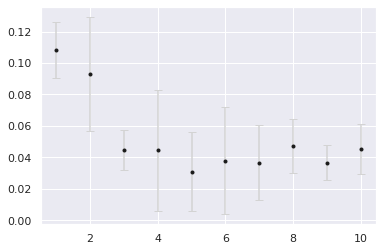

In [ ]:
avgErrors = np.mean(errors, axis = 1)
errorVariance = np.var(errors, axis =1)

#Variance is multiplied by 100 so it can be seen more easily
plt.errorbar(list(range(1,11,1)), avgErrors, errorVariance*100, fmt='.k', ecolor='lightgray', capsize = 4)

Variance in the above graph is multiplied by 100 to make it easier to see. Since 5 has the lowest average testing error, it will be used for the implementation of KNN.

#Method Comparison

Quantitative Analysis

In [ ]:
df_test = master_test.copy()
naiveBayesEvalTime = time.time()
confMatrixNaive = np.zeros([2,2])
confMatrixNaiveNormalized = np.zeros([2,2])
for i in range(df_test.shape[0]):
  predicted = runNaiveBayes(df_test.iloc[i])
  actual = int(df_test['decision'].iloc[i])
  confMatrixNaive[actual,predicted] += 1
confMatrixNaiveNormalized[0,:] = confMatrixNaive[0,:]/df_test['decision'].value_counts()[0]
confMatrixNaiveNormalized[1,:] = confMatrixNaive[1,:]/df_test['decision'].value_counts()[1]
naiveBayesEvalTime = time.time()-naiveBayesEvalTime

Seaborn heatmap is used to make the confusion matrix look aesthetically pleasing. It changes the color of a square based on its value.

In [ ]:
df_test = master_test.copy()
df_test['decision'] = df_test['decision'].replace(to_replace = [0,1], value = ['unacc', 'acc'])
intValue = {'unacc':0, 'acc':1}
treeEvalTime = time.time()
confMatrixTree = np.zeros([2,2])
confMatrixTreeNormalized = np.zeros([2,2])
for i in range(df_test.shape[0]):
  predicted = intValue[classify(df_test.iloc[i], treeClassifier)]
  actual = intValue[df_test['decision'].iloc[i]]
  confMatrixTree[actual,predicted] += 1
confMatrixTreeNormalized[0,:] = confMatrixTree[0,:]/df_test['decision'].value_counts()[0]
confMatrixTreeNormalized[1,:] = confMatrixTree[1,:]/df_test['decision'].value_counts()[1]
treeEvalTime = time.time()-treeEvalTime

In [ ]:
intValue = {'unacc':0, 'acc':1}
KNNEvalTime = time.time()
confMatrixKNN = np.zeros([2,2])
confMatrixKNNNormalized = np.zeros([2,2])
for i in range(testDf.shape[0]):
  topK= fastKNN(testDf.iloc[i][1:], 5, trainDf)
  numUnacc = sum(topK[0:5])
  pred = 0
  if(numUnacc > 2.5):
    pred = 1
  actual = intValue[df_test['decision'].iloc[i]]
  confMatrixKNN[actual,pred] += 1
confMatrixKNNNormalized[0,:] = confMatrixKNN[0,:]/df_test['decision'].value_counts()[0]
confMatrixKNNNormalized[1,:] = confMatrixKNN[1,:]/df_test['decision'].value_counts()[1]
KNNEvalTime = time.time() - KNNEvalTime

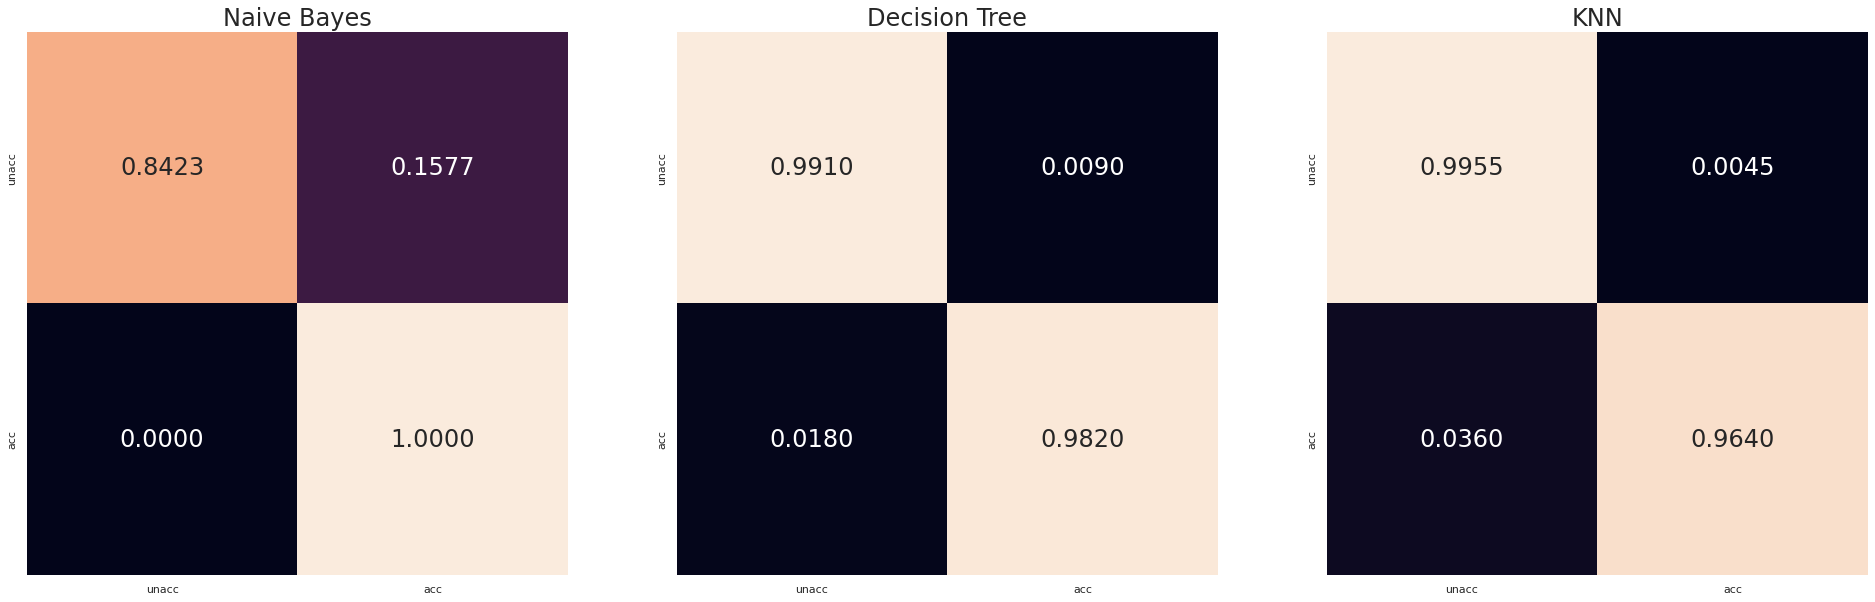

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = [33,10])
sn.set(font_scale = 2)

df_cmNaive = pd.DataFrame(confMatrixNaiveNormalized, index = ['unacc', 'acc'], columns = ['unacc','acc'])
sn.heatmap(df_cmNaive,annot=True, ax = ax1,  fmt='.4f', cbar = False)

df_cmTree = pd.DataFrame(confMatrixTreeNormalized, index = ['unacc', 'acc'], columns = ['unacc','acc'])
sn.heatmap(df_cmTree,annot=True, ax=ax2,  fmt='.4f', cbar = False)

df_cmKNN = pd.DataFrame(confMatrixKNNNormalized, index = ['unacc', 'acc'], columns = ['unacc','acc'])
sn.heatmap(df_cmKNN,annot=True, ax=ax3,  fmt='.4f', cbar = False)
ax1.set_title("Naive Bayes")
ax2.set_title("Decision Tree")
ax3.set_title("KNN")

plt.show()

In the above confusion matricies, it is shown that each classification method has a very low false positive rate. In addition, they all have high true negative rates

Actual is the rows
Predicted is the columns

In [ ]:
def values(confMatrix):
  tp = confMatrix[0,0]
  tn = confMatrix[1,1]
  fp = confMatrix[1,0]
  fn = confMatrix[0,1]
  recall = tp/(tp+fn)
  prec = tp/(tp+fp)
  fscore = (2*recall*prec)/(recall + prec)
  acc = (tp+tn)/(tp+tn+fp+fn)
  return recall, prec, fscore, acc

recallNaive , precNaive, fscoreNaive,accNaive = values(confMatrixNaive)
recallTree, precTree, fscoreTree, accTree = values(confMatrixTree)
recallKNN, precKNN, fscoreKNN, accKNN = values(confMatrixKNN)

print('Naive Bayes: Recall = {:.3f}; Precision = {:.3f}; F-Score = {:.3f}; Accuracy = {:.3f}'.format(recallNaive, precNaive, fscoreNaive,accNaive))
print('Decision Tree: Recall = {:.3f}; Precision = {:.3f}; F-Score = {:.3f}; Accuracy = {:.3f}'.format(recallTree, precTree, fscoreTree,accTree))
print('KNN: Recall = {:.3f}; Precision = {:.3f}; F-Score = {:.3f}; Accuracy = {:.3f}'.format(recallKNN, precKNN, fscoreKNN,accKNN))

Naive Bayes: Recall = 0.842; Precision = 1.000; F-Score = 0.914; Accuracy = 0.895
Decision Tree: Recall = 0.991; Precision = 0.991; F-Score = 0.991; Accuracy = 0.988
KNN: Recall = 0.995; Precision = 0.982; F-Score = 0.989; Accuracy = 0.985


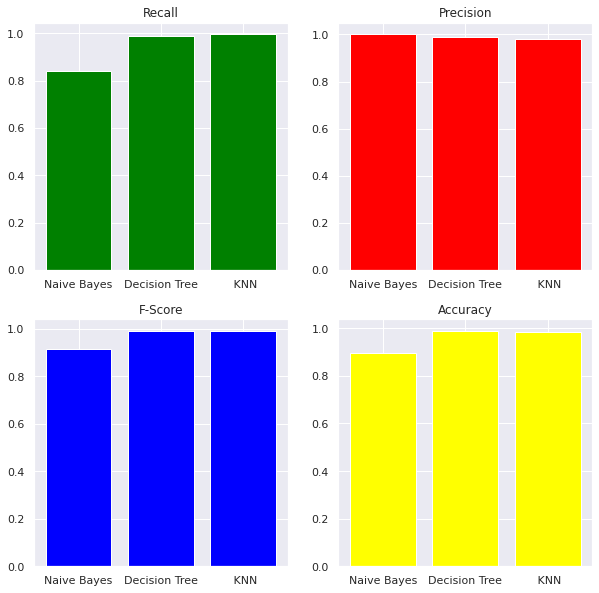

In [ ]:
sn.set(font_scale = 1)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = [10,10])

ax1.bar(x = ['Naive Bayes', 'Decision Tree', ' KNN'], height = [recallNaive,recallTree,recallKNN], color = 'green')
ax1.set_title("Recall")

ax2.bar(x = ['Naive Bayes', 'Decision Tree', ' KNN'], height = [precNaive,precTree,precKNN],color ='red')
ax2.set_title("Precision")

ax3.bar(x = ['Naive Bayes', 'Decision Tree', ' KNN'], height = [fscoreNaive,fscoreTree,fscoreKNN],color ='blue')
ax3.set_title("F-Score")

ax4.bar(x = ['Naive Bayes', 'Decision Tree', ' KNN'], height = [accNaive,accTree,accKNN],color ='yellow')
ax4.set_title("Accuracy")
plt.show()

In the above graphs, one can see the recall, precision, F-Score, and accuracy for each classification method. Naive Bayes is always lower than the other two, however the other two are ver similar. This indicates that Decision Tree and KNN have similar performance.

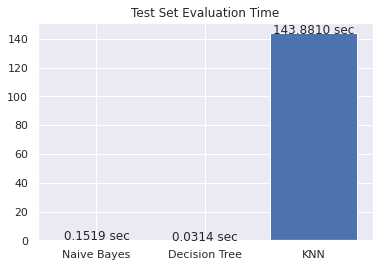

In [ ]:
fig = plt.figure()
plt.bar(x = ["Naive Bayes", "Decision Tree", "KNN"], height = [naiveBayesEvalTime, treeEvalTime, KNNEvalTime])
plt.text("Naive Bayes", naiveBayesEvalTime, "{:.4f} sec".format(naiveBayesEvalTime), ha = 'center')
plt.text("Decision Tree", treeEvalTime, "{:.4f} sec".format(treeEvalTime), ha = 'center')
plt.text("KNN", KNNEvalTime, "{:.4f} sec".format(KNNEvalTime), ha = 'center')
plt.title("Test Set Evaluation Time")
plt.show()

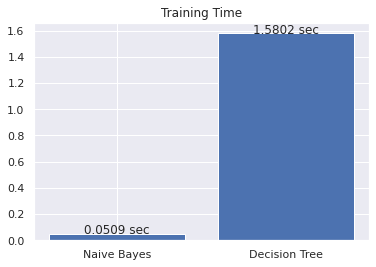

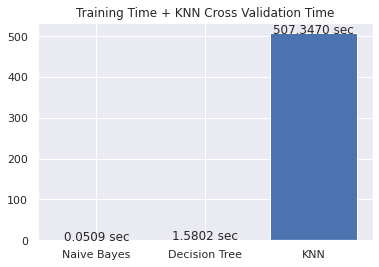

In [ ]:
fig = plt.figure()
plt.bar(x = ["Naive Bayes", "Decision Tree"], height = [naiveBayesTrainTime, treeTrainTime])
plt.text("Naive Bayes", naiveBayesTrainTime, "{:.4f} sec".format(naiveBayesTrainTime), ha = 'center')
plt.text("Decision Tree", treeTrainTime, "{:.4f} sec".format(treeTrainTime), ha = 'center')
plt.title("Training Time")
plt.show()

fig = plt.figure()
plt.bar(x = ["Naive Bayes", "Decision Tree", "KNN"], height = [naiveBayesTrainTime, treeTrainTime, KNNCrossValTime])
plt.text("Naive Bayes", naiveBayesTrainTime, "{:.4f} sec".format(naiveBayesTrainTime), ha = 'center')
plt.text("Decision Tree", treeTrainTime, "{:.4f} sec".format(treeTrainTime), ha = 'center')
plt.text("KNN", KNNCrossValTime, "{:.4f} sec".format(KNNCrossValTime), ha = 'center')
plt.title("Training Time + KNN Cross Validation Time")
plt.show()

In the above 2 cells, one can see that KNN takes much longer than Naive Bayes and Decision Tree in both training and testing time. This is most likely due to the number of loops that KNN must run through to calculate a prediction.

#Recommendation

The recommended algorithm for this task is Decision Tree. This is because of multiple reasons. First, it is performs better than Naive Bayes and is very close in performance to KNN. In addition, it takes much less time to train and evaluate than KNN. This indicates that it is the best classifier among these three.

#Ethical Issues

There are many ethical issues to be considered with this dataset. First, if this dataset is put into production, it is very important that a car is acceptable. There can be deadly consequences if an unacceptable car is deemed acceptable. In addition, these algorithms can be used for selling a car. If these algorithms are improperly trained, a customer could buy an unacceptable car. Cars are generally a large investment, so it is important that a good car is sold.

#Bibliography
For Decision Tree:

https://towardsdatascience.com/decision-tree-in-machine-learning-e380942a4c96

https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052

General Information:

ISL Textbook
